In [1]:
import os
import sys
import torch
import torch.nn as nn
import time
import matplotlib.pyplot as plt
import pickle
from datetime import datetime


# Add local snntorch repository to Python's path
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.insert(0, module_path)

import snntorch as snn
from snntorch._neurons.stateleaky import StateLeaky
from snntorch._neurons.leaky import Leaky

%matplotlib inline


In [2]:
# --- Setup ---
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Using device: {device}")

# --- Network Architecture Parameters ---
num_inputs = 784  # 28*28
num_hidden = 1000
num_outputs = 10
beta = 0.95 # For standard Leaky neuron

#==============================================================================
#  1. Network Definition for the new `StateLeaky` Neuron (No Time Loop)
#==============================================================================
class StateLeakyNet(nn.Module):
    """
    This network uses the convolutional `StateLeaky` neuron.
    It processes the entire time sequence in a single forward pass without a loop.
    """
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = StateLeaky(beta=beta, channels=num_hidden)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = StateLeaky(beta=beta, channels=num_outputs)

    def forward(self, x):
        cur1 = self.fc1(x)
        spk1, mem1 = self.lif1(cur1)
        cur2 = self.fc2(spk1)
        spk2, mem2 = self.lif2(cur2)
        return spk2, mem2

#==============================================================================
#  2. Network Definition for the standard `snn.Leaky` Neuron (With Time Loop)
#==============================================================================
class StandardLeakyNet(nn.Module):
    """
    This network uses the standard `snn.Leaky` neuron.
    It processes data one time step at a time using a classic for loop.
    """
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = Leaky(beta=beta)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = Leaky(beta=beta)

    def forward(self, x):
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        spk2_rec = []
        mem2_rec = []
        for step in range(x.shape[0]):
            cur1 = self.fc1(x[step])
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)
        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)


#==============================================================================
#  3. Benchmarking Functions
#==============================================================================
def get_peak_memory(device):
    """Gets the peak GPU memory usage in MB."""
    if device.type == 'cuda':
        return torch.cuda.max_memory_allocated(device) / 1024**2
    return 0

def test_inference_memory(network_class, device, batch_size=128, start_seq_len=50, step=50):
    """Tests memory and time during inference and returns results for plotting."""
    print(f"\n--- Starting INFERENCE Test for: {network_class.__name__} ---")
    net = network_class().to(device)
    net.eval()
    max_seq_len = getattr(net.lif1, 'max_timesteps', float('inf'))
    sequence_length = start_seq_len
    
    # Lists to store results
    seq_lens, peak_mems, exec_times = [], [], []

    while sequence_length <= max_seq_len:
        try:
            print(f"--> Testing Sequence Length: {sequence_length}")
            data = torch.rand(sequence_length, batch_size, num_inputs).to(device)
            
            if device.type == 'cuda':
                torch.cuda.reset_peak_memory_stats(device)
                torch.cuda.synchronize() # Wait for all previous GPU work to finish
            
            start_time = time.time()
            with torch.no_grad():
                spk_rec, mem_rec = net(data)
            end_time = time.time()
            
            if device.type == 'cuda':
                torch.cuda.synchronize() # Wait for the forward pass to complete
            
            duration = end_time - start_time
            peak_mem = get_peak_memory(device)
            print(f"Peak Memory: {peak_mem:.2f} MB | Execution Time: {duration:.4f} s")
            
            seq_lens.append(sequence_length)
            peak_mems.append(peak_mem)
            exec_times.append(duration)
            
            del data, spk_rec, mem_rec
            sequence_length += step
            time.sleep(0.1)

        except torch.cuda.OutOfMemoryError:
            print(f"\n💥 Out-of-Memory Error during INFERENCE at Sequence Length: {sequence_length}")
            return seq_lens, peak_mems, exec_times
        except KeyboardInterrupt:
            print("\nInference test stopped by user.")
            return seq_lens, peak_mems, exec_times
            
    print(f"\n✅ Inference test completed. Reached max sequence length: {int(max_seq_len)}")
    return seq_lens, peak_mems, exec_times


def test_training_memory(network_class, device, batch_size=128, start_seq_len=25, step=25):
    """Tests memory and time during training and returns results for plotting."""
    print(f"\n--- Starting TRAINING Test for: {network_class.__name__} ---")
    net = network_class().to(device)
    net.train()
    max_seq_len = getattr(net.lif1, 'max_timesteps', float('inf'))
    optimizer = torch.optim.Adam(net.parameters(), lr=1e-4)
    loss_fn = nn.CrossEntropyLoss()
    sequence_length = start_seq_len

    seq_lens, peak_mems, exec_times = [], [], []

    while sequence_length <= max_seq_len:
        try:
            print(f"--> Testing Sequence Length: {sequence_length}")
            data = torch.rand(sequence_length, batch_size, num_inputs).to(device)
            targets = torch.randint(0, num_outputs, (batch_size,)).to(device)

            if device.type == 'cuda':
                torch.cuda.reset_peak_memory_stats(device)
                torch.cuda.synchronize()

            start_time = time.time()
            spk_rec, _ = net(data)
            loss = loss_fn(spk_rec.sum(dim=0), targets)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            end_time = time.time()
            
            if device.type == 'cuda':
                torch.cuda.synchronize()

            duration = end_time - start_time
            peak_mem = get_peak_memory(device)
            print(f"Peak Memory: {peak_mem:.2f} MB | Execution Time: {duration:.4f} s")

            seq_lens.append(sequence_length)
            peak_mems.append(peak_mem)
            exec_times.append(duration)
            
            del data, targets, spk_rec, loss
            sequence_length += step
            time.sleep(0.1)

        except torch.cuda.OutOfMemoryError:
            print(f"\n💥 Out-of-Memory Error during TRAINING at Sequence Length: {sequence_length}")
            return seq_lens, peak_mems, exec_times
        except KeyboardInterrupt:
            print("\nTraining test stopped by user.")
            return seq_lens, peak_mems, exec_times
            
    print(f"\n✅ Training test completed. Reached max sequence length: {int(max_seq_len)}")
    return seq_lens, peak_mems, exec_times



#==============================================================================
#  4. Run Benchmarks
#==============================================================================

results = {}

# Run tests and store results
sl_inf_seq, sl_inf_mem, sl_inf_time = test_inference_memory(StateLeakyNet, device, batch_size=256)
results['state_leaky_inf'] = {'seq': sl_inf_seq, 'mem': sl_inf_mem, 'time': sl_inf_time}

sl_train_seq, sl_train_mem, sl_train_time = test_training_memory(StateLeakyNet, device, batch_size=256)
results['state_leaky_train'] = {'seq': sl_train_seq, 'mem': sl_train_mem, 'time': sl_train_time}

std_inf_seq, std_inf_mem, std_inf_time = test_inference_memory(StandardLeakyNet, device, batch_size=256)
results['standard_leaky_inf'] = {'seq': std_inf_seq, 'mem': std_inf_mem, 'time': std_inf_time}

std_train_seq, std_train_mem, std_train_time = test_training_memory(StandardLeakyNet, device, batch_size=256)
results['standard_leaky_train'] = {'seq': std_train_seq, 'mem': std_train_mem, 'time': std_train_time}

# Get the current time and format it into a string
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# Create the filename using an f-string
results_filename = f"benchmark_results_{timestamp}.pkl"

with open(results_filename, 'wb') as f:
    pickle.dump(results, f)

print(f"Generated filename: {results_filename}")

Using device: cuda

--- Starting INFERENCE Test for: StateLeakyNet ---
--> Testing Sequence Length: 50
Peak Memory: 341.44 MB | Execution Time: 0.0776 s
--> Testing Sequence Length: 100
Peak Memory: 820.17 MB | Execution Time: 0.0064 s
--> Testing Sequence Length: 150
Peak Memory: 1299.13 MB | Execution Time: 0.0104 s
--> Testing Sequence Length: 200
Peak Memory: 1778.77 MB | Execution Time: 0.0162 s
--> Testing Sequence Length: 250
Peak Memory: 2258.51 MB | Execution Time: 0.0555 s
--> Testing Sequence Length: 300
Peak Memory: 2738.51 MB | Execution Time: 0.0301 s
--> Testing Sequence Length: 350
Peak Memory: 3218.27 MB | Execution Time: 0.0384 s
--> Testing Sequence Length: 400
Peak Memory: 3698.09 MB | Execution Time: 0.0869 s
--> Testing Sequence Length: 450
Peak Memory: 4177.25 MB | Execution Time: 0.0576 s
--> Testing Sequence Length: 500
Peak Memory: 4657.16 MB | Execution Time: 0.0676 s
--> Testing Sequence Length: 550
Peak Memory: 5137.62 MB | Execution Time: 0.0793 s
--> Test

In [3]:
#==============================================================================
#  5. Plotting Function
#==============================================================================
def plot_results(results):
    """Generates plots comparing memory and time usage for different network types."""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 12))
    
    # --- Inference Memory Plot ---
    ax1.plot(results['state_leaky_inf']['seq'], results['state_leaky_inf']['mem'], 
             marker='o', linestyle='-', label='StateLeaky (Convolutional)')
    ax1.plot(results['standard_leaky_inf']['seq'], results['standard_leaky_inf']['mem'], 
             marker='x', linestyle='--', label='Standard Leaky (Recurrent)')
    ax1.set_title('Inference Memory Usage', fontsize=16)
    ax1.set_xlabel('Sequence Length', fontsize=12)
    ax1.set_ylabel('Peak Memory (MB)', fontsize=12)
    ax1.legend()
    ax1.grid(True, linestyle=':', alpha=0.6)

    # --- Training Memory Plot ---
    ax2.plot(results['state_leaky_train']['seq'], results['state_leaky_train']['mem'], 
             marker='o', linestyle='-', label='StateLeaky (Convolutional)')
    ax2.plot(results['standard_leaky_train']['seq'], results['standard_leaky_train']['mem'], 
             marker='x', linestyle='--', label='Standard Leaky (Recurrent)')
    ax2.set_title('Training Memory Usage', fontsize=16)
    ax2.set_xlabel('Sequence Length', fontsize=12)
    ax2.set_ylabel('Peak Memory (MB)', fontsize=12)
    ax2.legend()
    ax2.grid(True, linestyle=':', alpha=0.6)
    
    # --- Inference Time Plot ---
    ax3.plot(results['state_leaky_inf']['seq'], results['state_leaky_inf']['time'], 
             marker='o', linestyle='-', label='StateLeaky (Convolutional)')
    ax3.plot(results['standard_leaky_inf']['seq'], results['standard_leaky_inf']['time'], 
             marker='x', linestyle='--', label='Standard Leaky (Recurrent)')
    ax3.set_title('Inference Execution Time', fontsize=16)
    ax3.set_xlabel('Sequence Length', fontsize=12)
    ax3.set_ylabel('Time (seconds)', fontsize=12)
    ax3.legend()
    ax3.grid(True, linestyle=':', alpha=0.6)

    # --- Training Time Plot ---
    ax4.plot(results['state_leaky_train']['seq'], results['state_leaky_train']['time'], 
             marker='o', linestyle='-', label='StateLeaky (Convolutional)')
    ax4.plot(results['standard_leaky_train']['seq'], results['standard_leaky_train']['time'], 
             marker='x', linestyle='--', label='Standard Leaky (Recurrent)')
    ax4.set_title('Training Execution Time', fontsize=16)
    ax4.set_xlabel('Sequence Length', fontsize=12)
    ax4.set_ylabel('Time (seconds)', fontsize=12)
    ax4.legend()
    ax4.grid(True, linestyle=':', alpha=0.6)
    
    fig.suptitle('Performance Benchmark: StateLeaky vs. Standard Leaky Neuron', fontsize=20)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

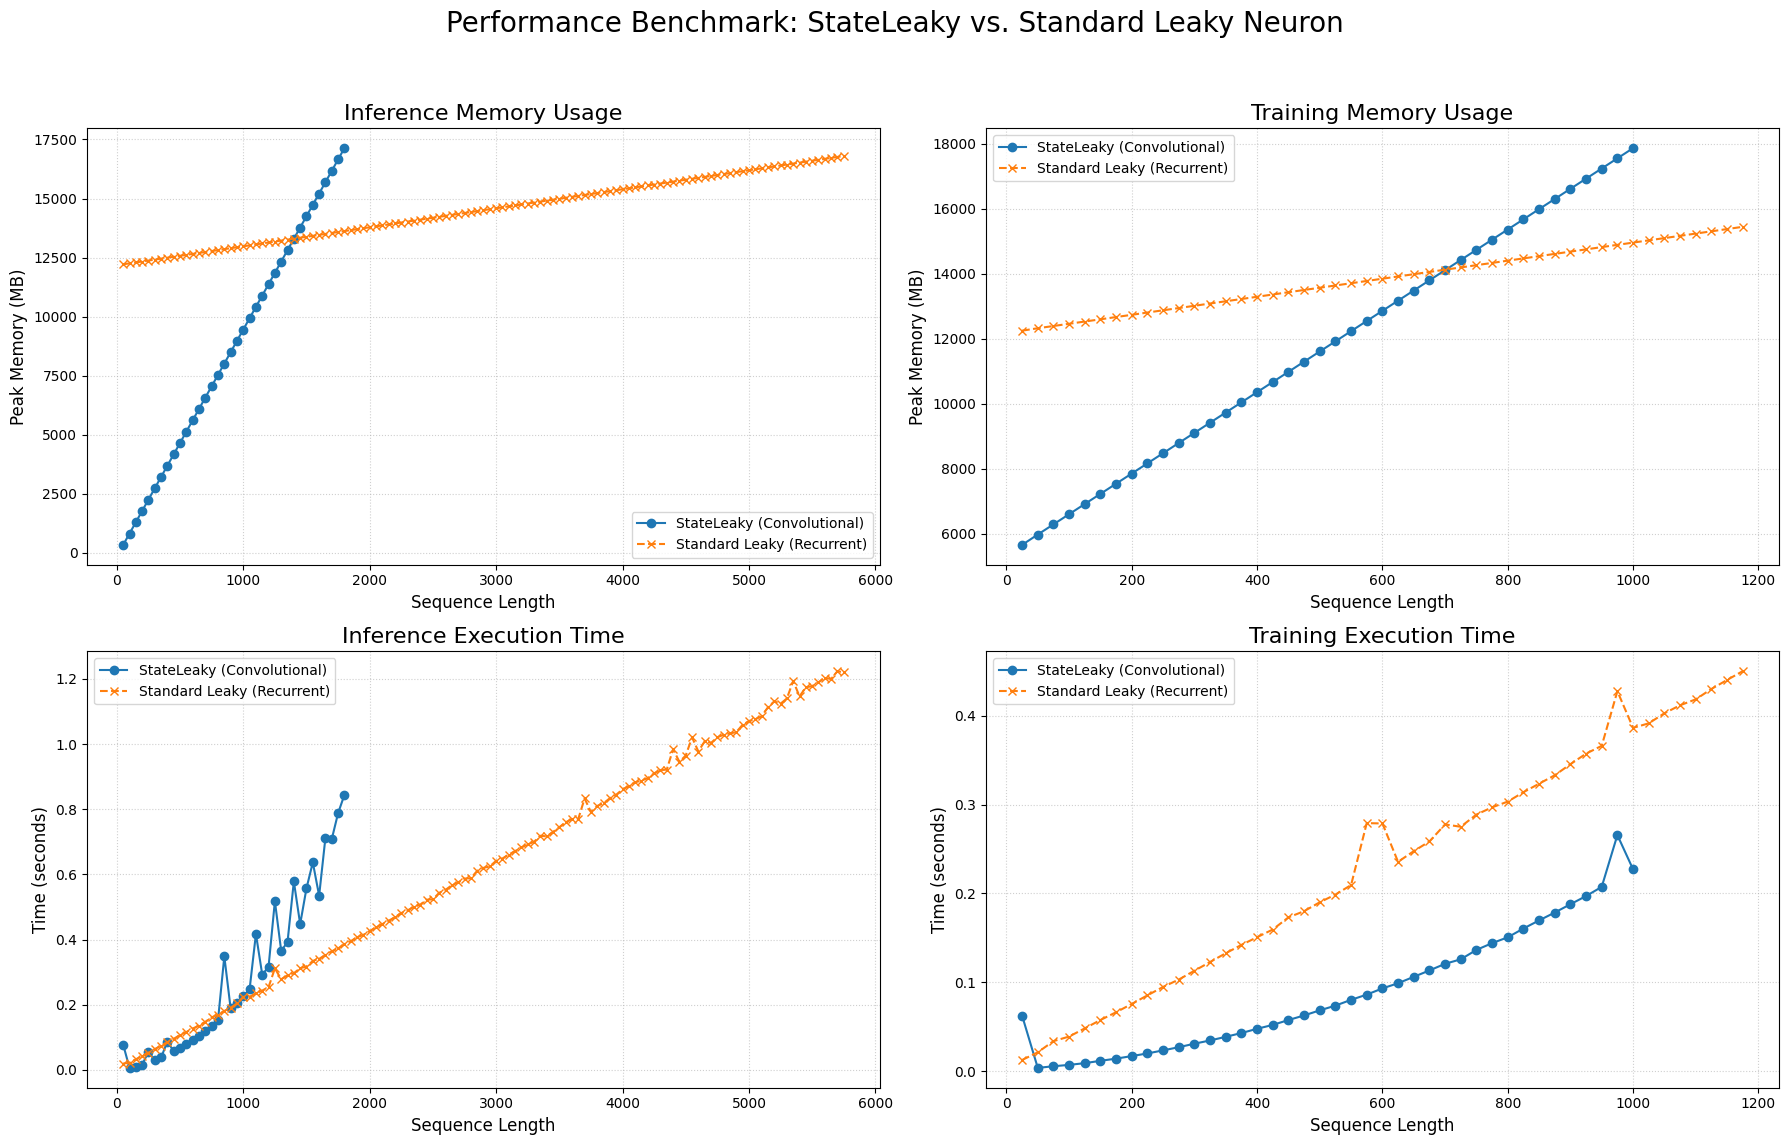

In [4]:
with open(results_filename, 'rb') as f:
    loaded_results = pickle.load(f)

if any(res['seq'] for res in loaded_results.values()):
    plot_results(loaded_results)